# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from collections import Counter
import re

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        z = np.dot(X, weights.T)
        y_pred = 1 / (1 + np.exp(-z))
        return y_pred
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        y_pred = self.get_sigmoid(x, weights)
        loss = - (np.sum(np.dot(y, np.log(y_pred)) + np.dot((1 - y), np.log(1 - y_pred))) + 
                  (np.sqrt(np.sum(weights ** 2)) / (2 * self.C))) / y.shape[0]
        return loss
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        num_samples = X_ext.shape[0]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        self.all_losses = []
        for i in range(self.max_iter):
            y_pred = self.get_sigmoid(X_ext, self.weights_)
            dz = y_pred - y
            dz = dz.reshape((-1, 1))
            
            delta = (np.sum(np.multiply(X_ext, dz), axis = 0) / num_samples) + ((self.weights_ / self.C) / num_samples)
            prev_weights = self.weights_.copy()
            
            self.weights_ -= self.eta * delta
            l2_w = np.sqrt(np.sum((self.weights_ - prev_weights) ** 2))
            
            self.all_losses.append(self.get_loss(X_ext,  self.weights_, y))

            if l2_w < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        prediction = self.get_sigmoid(X_ext, self.weights_)
        prediction = np.where(prediction > 0.5, 1, 0)
        return prediction

In [5]:
from sklearn import datasets
from sklearn import metrics

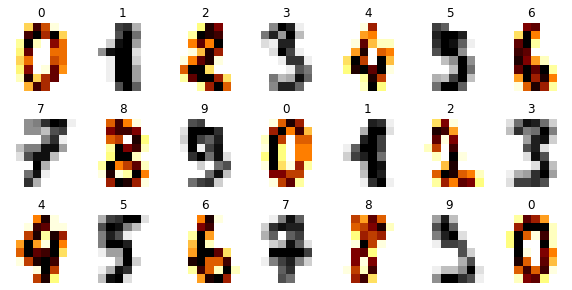

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

In [12]:
"""assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)"""

'assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,\n        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,\n        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,\n        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,\n       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,\n        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,\n        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,\n       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,\n        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,\n        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,\n       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,\n       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,\n        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [13]:
model = CustomLogisticRegression()

In [14]:
y_train = np.where(y_train == -1, 0, 1)
y_test = np.where(y_test == -1, 0, 1)

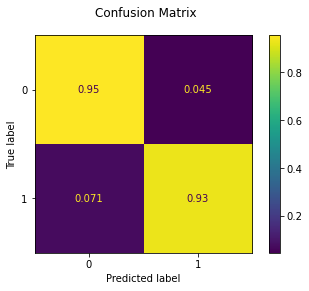

In [15]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [16]:
train_acc, test_acc

(0.9144050104384134, 0.9416666666666667)

In [17]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

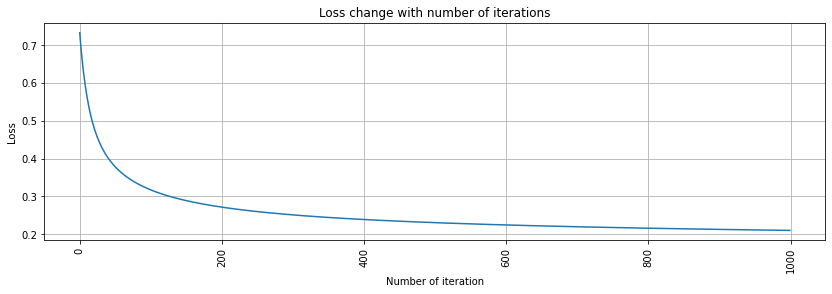

In [18]:
plt.figure(figsize = (14, 4))
plt.plot(np.arange(len(model.all_losses)), model.all_losses)
plt.title('Loss change with number of iterations')
plt.grid(True)
plt.xticks(rotation = 90)
plt.xlabel('Number of iteration')
plt.ylabel('Loss')
plt.show()

As shown in the graph above, loss becomes lower with each iteration, in such way the model searches for the best weights.

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [19]:
etas = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.002]
scores = []

for eta in etas:
    model_eta = CustomLogisticRegression(eta = eta)
    model_eta.fit(X_train, y_train)
    pred_eta = model_eta.predict(X_test)
    scores.append(f1_score(pred_eta, y_test))

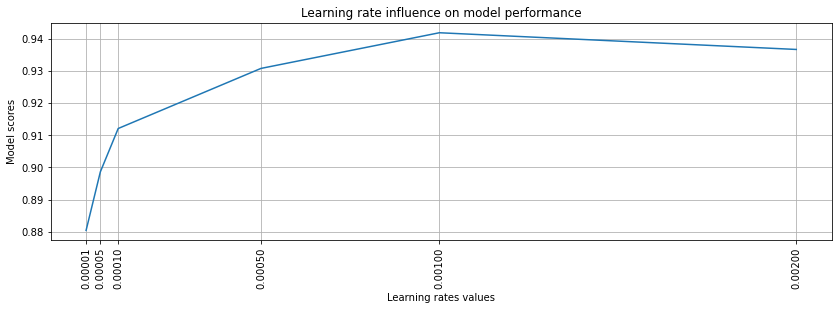

In [20]:
plt.figure(figsize = (14, 4))
plt.plot(etas, scores)
plt.title('Learning rate influence on model performance')
plt.xticks(etas)
plt.grid(True)
plt.xticks(rotation = 90)
plt.xlabel('Learning rates values')
plt.ylabel('Model scores')
plt.show()

Learning rate should be chosen for each model individually. As a rule, optimum learning rate makes training faster and the model converges better. For the current model the best value of learning rate is 0.001.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [21]:
Cs = [0.5, 1, 5, 10, 15, 20]
scores = []

for C in Cs:
    model_c = CustomLogisticRegression(C = C)
    model_c.fit(X_train, y_train)
    pred_c = model_c.predict(X_test)
    scores.append(f1_score(pred_c, y_test))

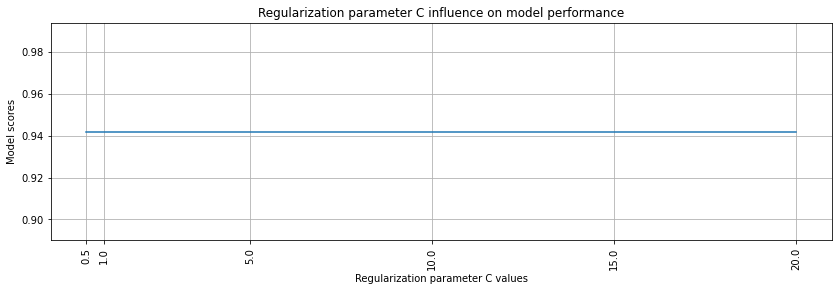

In [22]:
plt.figure(figsize = (14, 4))
plt.plot(Cs, scores)
plt.title('Regularization parameter C influence on model performance')
plt.xticks(Cs)
plt.grid(True)
plt.xticks(rotation = 90)
plt.xlabel('Regularization parameter C values')
plt.ylabel('Model scores')
plt.show()

**(0.5 points)** Compare zero initialization and random initialization. 

In [23]:
pred_rand_init = model.predict(X_test)
score_rand_init = f1_score(pred_rand_init, y_test)
print('F1 score with random weights initialization: ', round(score_rand_init, 4))

model_zero_init = CustomLogisticRegression(zero_init = True)
model_zero_init.fit(X_train, y_train)
model_zero_init.fit(X_train, y_train)
pred_zero_init = model_zero_init.predict(X_test)
score_zero_init = f1_score(pred_zero_init, y_test)
print('F1 score with zero weights initialization: ', round(score_zero_init, 4))

F1 score with random weights initialization:  0.9418
F1 score with zero weights initialization:  0.9448


The model shows slightly better F1 score with zero weight initialization.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [24]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        
        n_samples = X.shape[0]
        n_features = X.shape[1]
        k_samples = Y.shape[0]
        distances = np.empty((n_samples, k_samples))
        
        ''' Implementation using two cycles:
        for i in range(0, k_samples):
            for j in range(0, n_samples):
                distances[j, i] = np.sqrt(np.sum((X[j, :] - Y[i, :])**2))'''
        
        for i in range(0, k_samples):
            distances[:, i] = np.sqrt(np.sum((X - Y[i, :])**2, axis = 1)) 
        return distances
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """

        class_weights = np.empty((len(self.classes_)), dtype = np.int32)
        class_to_weight = dict(zip(y, weights))
        
        for i in range(len(self.classes_)): 
            class_weights[i] = np.sum(y == self.classes_[i]) * class_to_weight[self.classes_[i]]
        return class_weights


    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            print('X', X.shape)
            P = self.get_pairwise_distances(X, self.points)
            print('P', P.shape)
            
            weights_of_points = np.ones(P.shape)
            print('Shape', weights_of_points.shape)
            if self.weights == 'distance':
                weights_of_points = 1 / (P + self.eps)
                
            # <your code>
            pass
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """

        prediction = np.empty((X.shape[0]), dtype = '<U1')
        distances = self.get_pairwise_distances(self.points, X)
        indices = np.argsort(distances, axis = 0)[: self.n_neighbors, :]

        for i in range(X.shape[0]):
            k_neighbors = [self.y[j] for j in indices[:, i]]
            prediction[i] = Counter(k_neighbors).most_common(1)[0][0]

        return prediction

In [25]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [26]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [27]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

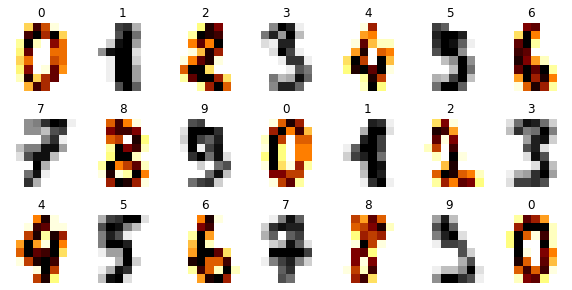

In [28]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [29]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [30]:
#assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

In [31]:
#train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

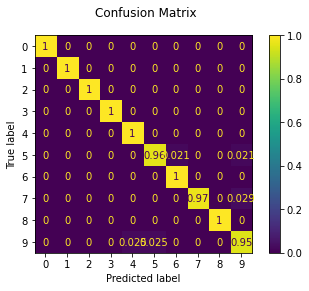

In [32]:
train_acc, test_acc = fit_evaluate(knn, X_train, y_train, X_test, y_test)

In [33]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

The model confuses the following pairs: (9, 4), (9, 5), (5, 6), (7, 9). The confusion is caused similiraty in writing of the mentioned pairs.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

Number of nearest neighbors is  1


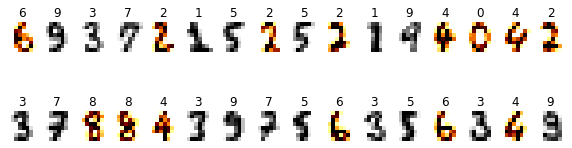

Number of nearest neighbors is  10


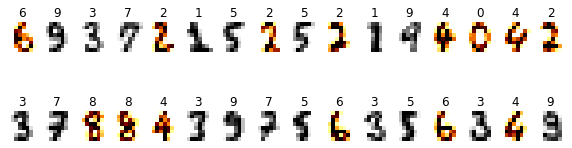

Number of nearest neighbors is  20


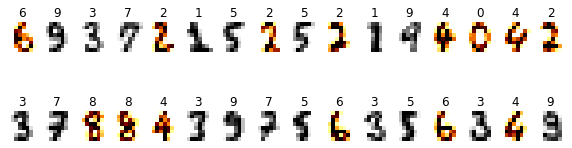

Number of nearest neighbors is  100


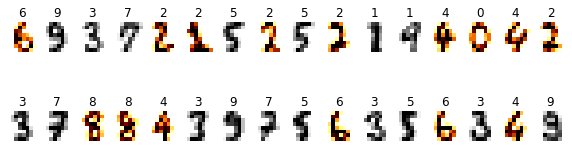

In [34]:
k_neighbors = [1, 10, 20, 100]
prediction = []

for k in k_neighbors:
    print('Number of nearest neighbors is ', k)
    knn_model = KNeighborsClassifier(n_neighbors = k, weights='distance')
    knn_model.fit(X_train, y_train)
    prediction.append(knn_model.predict(X_test))
    figure, axes = plt.subplots(nrows=2, ncols=16, figsize=(10, 3))
    for ax, image, label in zip(axes.flatten(), X_test, prediction[-1]):
        ax.set_axis_off()
        ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
        ax.set_title(label)
    plt.show()

In [35]:
for i in range(len(k_neighbors)):
    wrong = np.sum(y_test != prediction[i])
    print('Using {} nearest neighbors number of incorrect predictions is {}. '.format(k_neighbors[i], wrong))

Using 1 nearest neighbors number of incorrect predictions is 8. 
Using 10 nearest neighbors number of incorrect predictions is 7. 
Using 20 nearest neighbors number of incorrect predictions is 8. 
Using 100 nearest neighbors number of incorrect predictions is 21. 


In [36]:
k_neighbors = np.arange(1, 50, 1)
prediction = []
n_incorrect = []

for k in k_neighbors:
    knn_model = KNeighborsClassifier(n_neighbors = k, weights='distance')
    knn_model.fit(X_train, y_train)
    prediction.append(knn_model.predict(X_test))
    n_incorrect.append(np.sum(y_test != prediction[-1]))

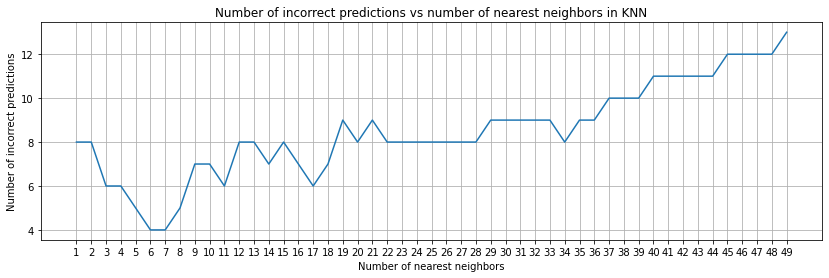

In [37]:
plt.figure(figsize = (14, 4))
plt.plot(k_neighbors, n_incorrect)
plt.title('Number of incorrect predictions vs number of nearest neighbors in KNN')
plt.xticks(k_neighbors)
plt.grid(True)
plt.xlabel('Number of nearest neighbors')
plt.ylabel('Number of incorrect predictions')
plt.show()

If number of nearest values is too small or too large the performance of the model is bad. There should be the golden mean, which provides the best performance. In current model, according to the above graph, the numbers of nearest neighbors for best model performance are 6 and 7.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [38]:
knn_distance = KNeighborsClassifier(n_neighbors=6, weights='distance')
knn_uniform = KNeighborsClassifier(n_neighbors=6, weights='uniform')
knn_distance.fit(X_train, y_train)
predict_distance = knn_distance.predict(X_test)
knn_uniform.fit(X_train, y_train)
predict_uniform = knn_uniform.predict(X_test)

print('Number of incorrect predictions in model with uniform weights: ', np.sum(predict_uniform != y_test))
print('Number of incorrect predictions in model with distance weights: ', np.sum(predict_distance != y_test))

Number of incorrect predictions in model with uniform weights:  4
Number of incorrect predictions in model with distance weights:  4


If the nearest neighbors vary widely in their distance, it is better to use distance weights, because the closest neighbors more reliably indicate the class of the object. For current dataset both models with uniform and distance weights show the same accuracy.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

The most common distance metrics for KNN model are 'euclidean', 'manhatten', 'chebyshev'. Lets compare models with these three metrics.

In [39]:
metrics = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
metric_comparison = pd.DataFrame(columns = metrics, index = ['Model score', 'Number of incorrect predictions'])

for metric in metrics:
    knn_model = KNeighborsClassifier(n_neighbors=6, metric=metric)
    knn_model.fit(X_train, y_train)
    score_model = knn_model.score(X_test, y_test)
    n_incorrect = np.sum(knn_model.predict(X_test) != y_test)
    series = pd.Series([round(score_model, 2), int(n_incorrect)], index = ['Model score', 'Number of incorrect predictions'])
    metric_comparison.loc[:, metric] = series
metric_comparison

,euclidean,manhattan,chebyshev,minkowski
Model score,0.99,0.98,0.98,0.99
Number of incorrect predictions,4.00,9.00,8.00,4.00


As shown in the table above the best performance is shown by models with 'euclidean' and 'minkowski' metrics, whereas, the worst performance is shown by model with 'manhatten' metric.

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [40]:
PATH = "./data/"

In [41]:
data = pd.read_csv('train.csv').set_index('PassengerId')

In [42]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [43]:
# Number of samples in the dataset

m = data.shape[0]

### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [44]:
counts = data.Sex.value_counts()
percentages = pd.Series(data = [100 * counts[0] / m, 100 * counts.iloc[1] / m], index = counts.index)
sex = pd.concat((counts, percentages), axis = 1).rename(columns={'Sex': 'Counts', 0: 'Percentages'})
sex

,Counts,Percentages
male,56114,56.114
female,43886,43.886


In [45]:
counts = data.Survived.value_counts()
percentages = pd.Series(data = [100 * counts[0] / m, 100* counts.iloc[1] / m], index = counts.index)
survived = pd.concat((counts, percentages), axis = 1).rename(columns={'Survived': 'Counts', 0: 'Percentages'})
survived

,Counts,Percentages
0,57226,57.226
1,42774,42.774


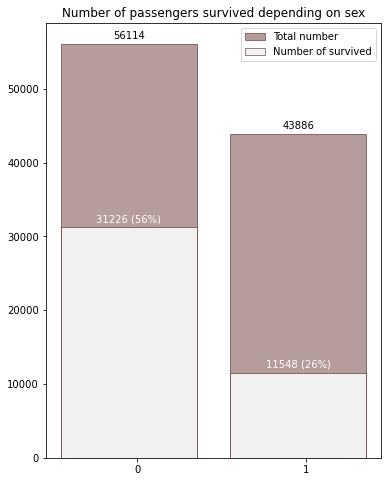

In [46]:
plt.figure(figsize = (6, 8))
r1 = data['Sex'].value_counts().values
r2 = data[data['Survived'] == 1]['Sex'].value_counts().values
x = np.arange(len(data['Sex'].unique()))
width = 0.1
rect1 = plt.bar(x - width / 2, r1, label = "Total number", color = "#b59d9b", edgecolor = "#3d0909", linewidth = 0.5)
rect2 = plt.bar(x - width / 2, r2, label = "Number of survived", color = "#f1f1f1", edgecolor = "#3d0909", linewidth = 0.5)
plt.title("Number of passengers survived depending on sex")
plt.legend()
plt.xticks([0, 1])
for rect1, rect2 in zip(rect1, rect2):
    height1 = rect1.get_height()
    height2 = rect2.get_height()
    plt.annotate("{}".format(height1), xy = (rect1.get_x() + rect1.get_width() / 2, height1), 
                    xytext = (0, 3), textcoords = "offset points", ha = "center", va = "bottom") 
    plt.annotate("{} ({}%)".format(height2, int(round(height2*100/height1, 0))), xy = (rect2.get_x() + 
                    rect2.get_width() / 2, height2), xytext = (0, 3), textcoords = "offset points", 
                    ha = "center", va = "bottom", color = "#ffffff")
plt.show()

0 - corresponds to males, 1 - corresponds to females <br>
There were more male than female onboard. Men had more chance to survive on Titanic.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

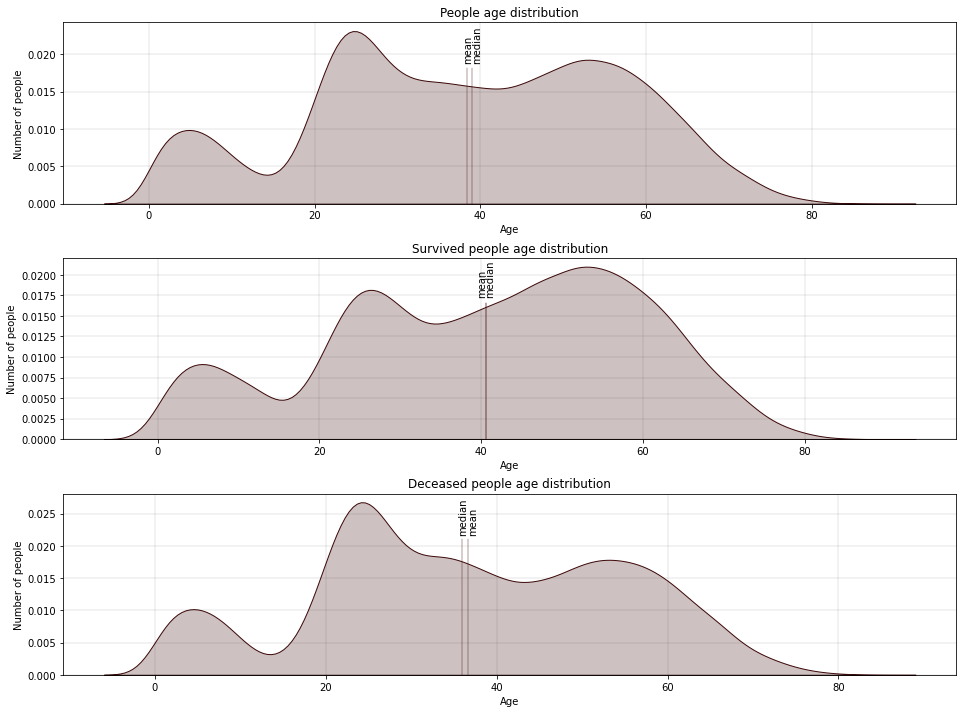

In [47]:
figure, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (16, 12))
figure.subplots_adjust(hspace = 0.3)  

ax1.set_title('People age distribution')
ax1.grid(linewidth = 0.1, color = "#000000")
sns.kdeplot(data = data['Age'], color = '#3d0909', shade=True, ax = ax1)
ax1.axvline(x = np.mean(data['Age']), color = '#3d0909', ymax = 0.75, linewidth = 0.4)
ax1.text(np.mean(data['Age'] - 0.5), 0.019, 'mean', rotation=90)
ax1.axvline(x = np.median(data['Age'].dropna()), color = '#3d0909', ymax = 0.75, linewidth = 0.4)
ax1.text(np.median(data['Age'].dropna()), 0.019, 'median', rotation=90)
ax1.set_xlabel('Age')
ax1.set_ylabel('Number of people')

ax2.set_title('Survived people age distribution')
ax2.grid(linewidth = 0.1, color = "#000000")
sns.kdeplot(data = data[data['Survived'] == 1]['Age'], color = '#3d0909', shade=True, ax = ax2)
ax2.axvline(x = np.mean(data[data['Survived'] == 1]['Age']), color = '#3d0909', ymax = 0.75, linewidth = 0.4)
ax2.text(np.mean(data[data['Survived'] == 1]['Age'] - 1), 0.0175, 'mean', rotation=90)
ax2.axvline(x = np.mean(data[data['Survived'] == 1]['Age'].dropna()), color = '#3d0909', ymax = 0.75, linewidth = 0.4)
ax2.text(np.mean(data[data['Survived'] == 1]['Age'].dropna()), 0.0175, 'median', rotation=90)
ax2.set_xlabel('Age')
ax2.set_ylabel('Number of people')

ax3.set_title('Deceased people age distribution')
ax3.grid(linewidth = 0.1, color = "#000000")
sns.kdeplot(data = data[data['Survived'] == 0]['Age'], color = '#3d0909', shade=True, ax = ax3)
ax3.axvline(x = np.mean(data[data['Survived'] == 0]['Age']), color = '#3d0909', ymax = 0.75, linewidth = 0.4)
ax3.text(np.mean(data[data['Survived'] == 0]['Age']), 0.022, 'mean', rotation=90)
ax3.axvline(x = np.median(data[data['Survived'] == 0]['Age'].dropna()), color = '#3d0909', ymax = 0.75, linewidth = 0.4)
ax3.text(np.median(data[data['Survived'] == 0]['Age'].dropna() - 0.5), 0.022, 'median', rotation=90)
ax3.set_xlabel('Age')
ax3.set_ylabel('Number of people')
plt.show()

The diagrams above show that avarage age of survived people is higher than of people who deceased. Many elderly people (age 45 - 65) were evacuated from Titanic, whereas, many young people (age 20 - 30) died. That could be explained by priority evacuation for elderly, or by the fact that older people had more money and as a result higher ticket class.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

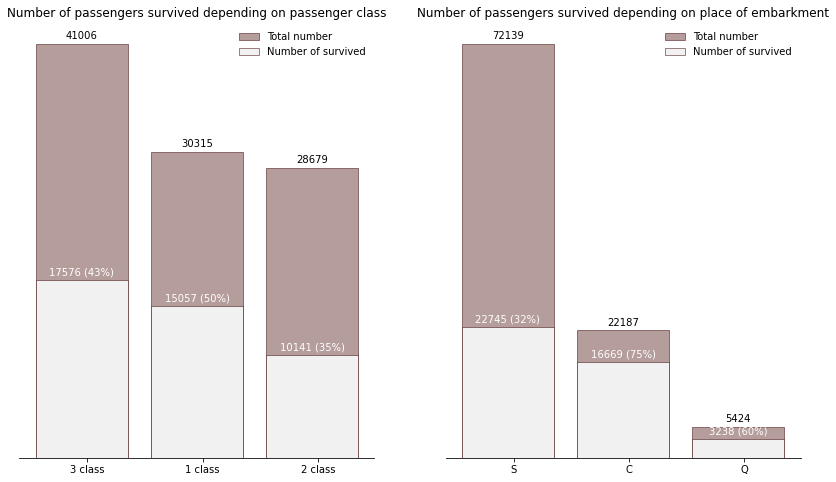

In [48]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 8))

r1 = data['Pclass'].value_counts().values
r2 = data[data['Survived'] == 1]['Pclass'].value_counts().values
width = 0.1
x = np.arange(len(data['Pclass'].unique()))
rect1 = ax1.bar(x - width / 2, r1, label = "Total number", color = "#b59d9b", edgecolor = "#3d0909", linewidth = 0.5)
rect2 = ax1.bar(x - width / 2, r2, label = "Number of survived", color = "#f1f1f1", edgecolor = "#3d0909", linewidth = 0.5)
ax1.set_xticks(x)
ax1.set_xticklabels([str(x) + ' class' for x in data['Pclass'].value_counts().index])
ax1.set_title("Number of passengers survived depending on passenger class")
ax1.set_ylabel("Number of passengers")
ax1.legend(frameon = False)
ax1.get_yaxis().set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)

for rect1, rect2 in zip(rect1, rect2):
    height1 = rect1.get_height()
    height2 = rect2.get_height()
    ax1.annotate("{}".format(height1), xy = (rect1.get_x() + rect1.get_width() / 2, height1), 
                    xytext = (0, 3), textcoords = "offset points", ha = "center", va = "bottom") 
    ax1.annotate("{} ({}%)".format(height2, int(round(height2*100/height1, 0))), xy = (rect2.get_x() + rect2.get_width() / 2, 
                    height2), xytext = (0, 3), textcoords = "offset points", ha = "center", va = "bottom", color = "#ffffff")
    
r1 = data['Embarked'].dropna().value_counts().values
r2 = data[data['Survived'] == 1]['Embarked'].dropna().value_counts().values
width = 0.1
x = np.arange(len(data['Embarked'].dropna().unique()))
rect1 = ax2.bar(x - width / 2, r1, label = "Total number", color = "#b59d9b", edgecolor = "#3d0909", linewidth = 0.5)
rect2 = ax2.bar(x - width / 2, r2, label = "Number of survived", color = "#f1f1f1", edgecolor = "#3d0909", linewidth = 0.5)
ax2.set_xticks(x)
ax2.set_xticklabels(data['Embarked'].value_counts().index)
ax2.set_title("Number of passengers survived depending on place of embarkment")
ax2.set_ylabel("Number of passengers")
ax2.legend(frameon = False)
ax2.get_yaxis().set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)

for rect1, rect2 in zip(rect1, rect2):
    height1 = rect1.get_height()
    height2 = rect2.get_height()
    ax2.annotate("{}".format(height1), xy = (rect1.get_x() + rect1.get_width() / 2, height1), 
                    xytext = (0, 3), textcoords = "offset points", ha = "center", va = "bottom") 
    ax2.annotate("{} ({}%)".format(height2, int(round(height2*100/height1, 0))), xy = (rect2.get_x() + rect2.get_width() / 2, 
                    height2), xytext = (0, 3), textcoords = "offset points", ha = "center", va = "bottom", color = "#ffffff")
    
plt.show()

Based on the left graph above, the safest class is '1 class' since 50% of these passengers survived. According to the right graph above, the safest place of embarkment was 'C', since 75% of passengers from this port survived.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [49]:
m = len(data)
number = data.isna().sum()
percentage = 100 * data.isna().sum() / m
missing_values = pd.DataFrame(data = [number, percentage], 
                              index = ['Number  of missing values', 'Percentage of missing values'])
missing_values

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Number of missing values,0.0,0.0,0.0,0.0,3292.000,0.0,0.0,4623.000,134.000,67866.000,250.00
Percentage of missing values,0.0,0.0,0.0,0.0,3.292,0.0,0.0,4.623,0.134,67.866,0.25


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

There are 5 features with missing points in the dataset. Each feature will be prepared separatly using different methods for missing values filling.

In [50]:
# Fare missing values filling
# Determine average prices for ticket of each class. These information can be used to fill gaps in 'Fare' column of the dataset

class_fare = data.groupby(['Pclass'])['Fare'].mean()

# Fill the Fare column of the dataset with mean price of the ticket according to the ticket class

data['Fare'] = data.apply((lambda df: class_fare.loc[df['Pclass']]
                                               if pd.isnull(df['Fare']) else df['Fare']), axis = 1)

In [51]:
# Embarked missing values filling
# Determine most common place of embarkment for survived and deceased passengers. 

survived_embarked = data.groupby(['Sex'])['Embarked'].value_counts()

survived = dict({(survived_embarked.index[i][0], survived_embarked.index[i][1]) for i in range(0, 6, 2)})

data['Embarked'] = data.apply((lambda df: survived[df['Sex']]
                                               if pd.isnull(df['Embarked']) else df['Embarked']), axis = 1)

In [52]:
# Analyse the column 'Age'. Check if there are fractional numbers. It is more reasonable to express age as an integer

data['Age'] = data['Age'].apply(lambda v: int(v) if pd.notna(v) else np.nan)

# The values that lower than 1 can indicate the infants, otherwise they are erroneous
# To check whether these values are indeed infants, check if they have parents onboard. Infants can't travel by themselves

zeros = data[data['Age'] == 0]
not_infants = data[(data['Parch'] == 0) & (data['Age'] == 0)]

# Replace zero age values related to adults with random values in the range of one standard deviation of the age distribution

mean = int(data['Age'].mean()) 
std = int(data['Age'].std())

for v in data['Age'][(data['Parch'] == 0) & (data['Age'] == 0)]:
    v = random.randint(mean - std, mean + std)
    
# Replace nan values with random values in range of one standard deviation of the age distribution

data['Age'].fillna(random.randint(mean - std, mean + std), inplace = True)

In [53]:
# It can be noticed that cabin number has alphabetic prefix, which could be correlated with ticket class
# Extract cabin class as a separate variable

data['Cabin class'] = data['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else np.nan)
data['Cabin number'] = data['Cabin'].apply(lambda s: s[1:] if pd.notnull(s) else np.nan)
data.drop(columns = ['Cabin'], inplace = True)

In [54]:
# Cabin missing values filling
# Determine most common cabin class for survived and deceased passengers. 

survived_cabin = data.groupby(['Pclass'])['Cabin class'].value_counts()

survived_cabin = dict({(survived_cabin.index[i][0], survived_cabin.index[i][1]) for i in range(0, 24, 8)})

data['Cabin class'] = data.apply((lambda df: survived_cabin[df['Pclass']]
                                               if pd.isnull(df['Cabin class']) else df['Cabin class']), axis = 1)

mean_cabin = data['Cabin number'].dropna().astype('int64').mean()
data['Cabin number'].fillna(mean_cabin, inplace = True)
data['Cabin number'] = data['Cabin number'].astype('int64')

In [55]:
# Ticket missing values filling

data['Ticket'] = data['Ticket'].astype('str')
data['Ticket'] = data.Ticket.apply(lambda x: re.sub("\D", "", x))
data['Ticket'] = data.Ticket.apply(lambda x: np.nan if x == '' else x)
mean_ticket = data['Ticket'].value_counts().index[1]
data['Ticket'].fillna(mean_ticket, inplace = True)

In [56]:
# Check missing values after filling

m = len(data)
number = data.isna().sum()
percentage = 100 * data.isna().sum() / m
missing_values = pd.DataFrame(data = [number, percentage], 
                              index = ['Number  of missing values', 'Percentage of missing values'])
missing_values

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin class,Cabin number
Number of missing values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percentage of missing values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [57]:
# Convert category values in numbers

data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
data['Cabin class'] = data['Cabin class'].map({'C': 0, 'E': 1, 'A': 2, 'D': 3, 'B': 4, 'F': 5, 'G': 6, 'T': 7})

In [58]:
# Training set and target values

X_train = data.drop(columns = ['Name', 'Survived'])
y_train = data['Survived']

print('Shape of input features:', X_train.shape)
print('Shape of target values:', y_train.shape)

Shape of input features: (100000, 10)
Shape of target values: (100000,)


In [59]:
# Scale the input data

scaler = MinMaxScaler(feature_range = (0, 7))
x_scaled = scaler.fit_transform(X_train[['Age', 'Fare', 'Cabin number', 'Ticket']])
x_scaled = np.hstack((x_scaled, X_train.drop(columns = ['Age', 'Fare', 'Cabin number', 'Ticket'])))

In [60]:
# Logistic Regression

log_model_cv = LogisticRegressionCV(Cs = 100, cv = 5, class_weight = 'balanced', 
                                    tol=0.00000001, max_iter = 100000, random_state=42)
log_model_cv.fit(x_scaled, y_train)
logreg_score = log_model_cv.score(x_scaled, y_train)
print('Logistic regression accuracy: ', logreg_score)

Logistic regression accuracy:  0.76054


In [61]:
# K nearest neighbors

knn_model = KNeighborsClassifier(n_neighbors = 10, weights='distance')
knn_model.fit(x_scaled, y_train)
knn_score = knn_model.score(x_scaled, y_train)
print('KNN accuracy: ', knn_score)

KNN accuracy:  0.99965


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [62]:
# Combine features SibSp and Parch into one feature

data['Accompany'] = data['SibSp'] + data['Parch']
data.drop(columns = ['SibSp', 'Parch'], inplace = True)

In [63]:
# Try model without column 'Ticket' and 'Cabin number'

X_train = data.drop(columns = ['Name', 'Survived'])
y_train = data['Survived']

scaler = MinMaxScaler(feature_range = (0, 7))
x_scaled = scaler.fit_transform(X_train[['Age', 'Fare']])
x_scaled = np.hstack((x_scaled, X_train.drop(columns = ['Age', 'Fare', 'Cabin number', 'Ticket'])))

In [64]:
# Logistic Regression

log_model_cv = LogisticRegressionCV(Cs = 100, cv = 5, class_weight = 'balanced', 
                                    tol=0.00000001, max_iter = 100000, random_state=42)
log_model_cv.fit(x_scaled, y_train)
logreg_score = log_model_cv.score(x_scaled, y_train)
print('Logistic regression training accuracy: ', logreg_score)

Logistic regression training accuracy:  0.76045


Model performance became better with combined features 'SibSp' and 'Parch'. Additionally try to tune logistic regression model to get better peformance.

In [65]:
log_reg = LogisticRegressionCV(max_iter = 100, cv = 2, random_state=42)

param = [{'penalty': ['l2'], 'Cs': [80, 95, 99], 'class_weight': ['balanced']}
        ]

grid_search = GridSearchCV(log_reg, param, scoring = 'accuracy')
grid_search.fit(x_scaled, y_train)

GridSearchCV(estimator=LogisticRegressionCV(cv=2, random_state=42),
             param_grid=[{'Cs': [80, 95, 99], 'class_weight': ['balanced'],
                          'penalty': ['l2']}],
             scoring='accuracy')

In [66]:
params = grid_search.best_params_
print('Best parameters: ', params)

Best parameters:  {'Cs': 80, 'class_weight': 'balanced', 'penalty': 'l2'}


In [67]:
log_reg_best = LogisticRegressionCV(max_iter = 10000, cv = 6, Cs = params['Cs'], 
                                  class_weight = params['class_weight'], 
                                  penalty = params['penalty'], random_state=42)
log_reg_best.fit(x_scaled, y_train)
log_reg_best_score = log_reg_best.score(x_scaled, y_train)
print('Logistic regression best training score: ',  log_reg_best_score)

Logistic regression best training score:  0.76039


In [68]:
log_reg = SGDClassifier(max_iter = 100, random_state=42,  loss = 'log', learning_rate = 'optimal', tol = 0.00000001)

param = [{'penalty': ['l2'], 'class_weight': ['balanced'], 'alpha': [0.002, 0.005, 0.01, 0.05],
          'power_t': [0.05, 0.1, 0.2, 0.5]}]

grid_search = GridSearchCV(log_reg, param, cv = 5, scoring = 'accuracy')
grid_search.fit(x_scaled, y_train)

GridSearchCV(cv=5,
             estimator=SGDClassifier(loss='log', max_iter=100, random_state=42,
                                     tol=1e-08),
             param_grid=[{'alpha': [0.002, 0.005, 0.01, 0.05],
                          'class_weight': ['balanced'], 'penalty': ['l2'],
                          'power_t': [0.05, 0.1, 0.2, 0.5]}],
             scoring='accuracy')

In [69]:
params = grid_search.best_params_
print('Best parameters: ', params)

Best parameters:  {'alpha': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'power_t': 0.05}


In [70]:
log_reg_best = SGDClassifier(max_iter = 10000, loss = 'log', alpha = params['alpha'], tol = 0.00000001,
                                  class_weight = params['class_weight'], power_t = params['power_t'],
                                  penalty = params['penalty'], random_state=42)
log_reg_best.fit(x_scaled, y_train)
log_reg_best_score = log_reg_best.score(x_scaled, y_train)
print('Logistic regression best training score: ',  log_reg_best_score)

Logistic regression best training score:  0.76174


Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [71]:
data_test = pd.read_csv('test.csv')

In [72]:
# Test data preprocessing 

data_test['Fare'] = data_test.apply((lambda df: class_fare.loc[df['Pclass']]
                                               if pd.isnull(df['Fare']) else df['Fare']), axis = 1)
    
data_test['Embarked'] = data_test.apply((lambda df: survived[df['Sex']]
                                               if pd.isnull(df['Embarked']) else df['Embarked']), axis = 1)
    
data_test['Age'] = data['Age'].apply(lambda v: int(v) if pd.notna(v) else np.nan)
    
for v in data_test['Age'][(data_test['Parch'] == 0) & (data_test['Age'] == 0)]:
    v = random.randint(mean - std, mean + std)
    
data_test['Age'].fillna(random.randint(mean - std, mean + std), inplace = True)
    
data_test['Cabin class'] = data_test['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else np.nan)
data_test['Cabin number'] = data_test['Cabin'].apply(lambda s: s[1:] if pd.notnull(s) else np.nan)
data_test.drop(columns = ['Cabin'], inplace = True)
    
data_test['Cabin class'] = data_test.apply((lambda df: survived_cabin[df['Pclass']]
                                               if pd.isnull(df['Cabin class']) else df['Cabin class']), axis = 1)

data_test['Cabin number'].fillna(mean_cabin, inplace = True)
data_test['Cabin number'] = data_test['Cabin number'].astype('int64')
    
data_test['Ticket'] = data_test['Ticket'].astype('str')
data_test['Ticket'] = data_test.Ticket.apply(lambda x: re.sub("\D", "", x))
data_test['Ticket'] = data.Ticket.apply(lambda x: np.nan if x == '' else x)
data_test['Ticket'].fillna(mean_ticket, inplace = True)

data_test['Accompany'] = data_test['SibSp'] + data_test['Parch']
data_test.drop(columns = ['SibSp', 'Parch'], inplace = True)
    
data_test['Sex'] = data_test['Sex'].map({'male': 0, 'female': 1})
data_test['Embarked'] = data_test['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
data_test['Cabin class'] = data_test['Cabin class'].map({'C': 0, 'E': 1, 'A': 2, 'D': 3, 'B': 4, 'F': 5, 'G': 6, 'T': 7})

In [73]:
X_test = data_test.drop(columns = ['Name', 'PassengerId'])

X_scaled_test = scaler.transform(X_test[['Age', 'Fare']])
X_scaled_test = np.hstack((X_scaled_test, X_test.drop(columns = ['Age', 'Fare', 'Cabin number', 'Ticket'])))

In [74]:
prediction_test = log_reg_best.predict(X_scaled_test)

In [75]:
# Create submission file for Kaggle

result = pd.DataFrame(data_test['PassengerId'])
prediction = pd.Series(prediction_test, name = 'Survived')
result = result.join(prediction).set_index(['PassengerId'])
result.to_csv('submission.csv')

According to Kaggle, the model shows 0.801 score on the test set.